In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
def read_output_data(filename):
    table = pd.read_excel(filename)
    # table.loc[table.subject == 'nm', 'subject'] = 'm'
    # table.loc[table.subject == 'nf', 'subject'] = 'm'
    # table.loc[(table.int_pos == 'A') | (table.int_pos == 'B'), 'int_pos'] = 'AB'
    # table.loc[(table.int_pos == 'C') | (table.int_pos == 'D'), 'int_pos'] = 'CD'
    return table.drop(columns=['date'])

In [3]:
# table = read_output_data('complete_output_data-dear_enemy-1.csv'); table.head()
table = read_output_data('intruder_tests_corrected_pair_id.xlsx'); table.head()

,tank_num,int_pos,pair_id,status,phase,cond,subject,app_int,app_n,app_p,fsp_int,fsp_n,fsp_p,sb_int,sb_n,sb_p,mwr_p,l_int,l_n
0,F5A,A,1,S,habituation,control,m,8.0,0.0,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,6.463,124.660
1,F5A,A,1,S,habituation,control,f,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.575,124.660
2,F5A,A,1,S,experiment,control,nm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.336,120.336
3,F5A,A,1,S,experiment,control,nf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.336,120.336
4,F5A,B,1,S,habituation,control,m,28.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.251,122.056


In [4]:
# match A-D & C-B for control, and A-A, B-B, etc for treatment
# always habituation minus experiment
table.loc[((table.subject == 'nm') | (table.subject == 'm')) & (table.pair_id == 1)]

,tank_num,int_pos,pair_id,status,phase,cond,subject,app_int,app_n,app_p,fsp_int,fsp_n,fsp_p,sb_int,sb_n,sb_p,mwr_p,l_int,l_n
0,F5A,A,1,S,habituation,control,m,8.0,0.0,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,6.463,124.660
2,F5A,A,1,S,experiment,control,nm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.336,120.336
4,F5A,B,1,S,habituation,control,m,28.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.251,122.056
6,F5A,B,1,S,experiment,control,nm,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,15.567,121.153
8,F5B,C,1,S,habituation,control,nm,10.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,9.349,120.000
10,F5B,C,1,S,experiment,control,m,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.383,19.813
12,F5B,D,1,S,habituation,control,nm,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.524,120.000
14,F5B,D,1,S,experiment,control,m,12.0,0.0,2.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,1.216,15.497


For the above `pair_id = 1 & male`; m: A-D = -4, B-C = 16; nm: D-A = 0; C-B = 9; *always* subtract hab - exp

In [5]:
ctbl = table.drop(columns=['tank_num']);

def get_matching_pos(str):
    if str == 'A':
        return ('D', 'AD')
    if str == 'B':
        return ('C', 'BC')
    if str == 'C':
        return ('B', 'BC')
    if str == 'D':
        return ('A', 'AD')
    assert False, str

res = pd.DataFrame([], columns=ctbl.columns).drop(columns='phase')
i = 0
for k,v in ctbl.groupby(['phase', 'int_pos', 'subject', 'pair_id']):
    if k[0] == 'habituation':
        assert len(v) == 1, v
        matching_pos, pos = get_matching_pos(k[1])
        subject = k[2]
        pair_id = k[3]
        cond = v.iloc(0)[0]['cond']
        status = v.iloc(0)[0]['status']
        
        if np.isnan(v.iloc(0)[0]['app_n']):
            print(f'Skipping NaN data: {k}')
            continue
        
        if cond == 'control' or cond == 'treatment':
            matched = ctbl.loc[(ctbl.phase == 'experiment') 
                           & (ctbl.subject == subject) 
                           & (ctbl.pair_id == pair_id) 
                           & (ctbl.int_pos == matching_pos)]
        else:
            assert False, k

        assert len(matched) == 1, v
        assert cond == matched.iloc(0)[0]['cond'], v
        assert status == matched.iloc(0)[0]['status'], v
        row = (v.iloc(0)[0]['app_int':] - matched.iloc(0)[0]['app_int':]).append(pd.Series({
            'int_pos': pos,
            'pair_id': pair_id,
            'subject': subject,
            'status': status,
            'cond': cond
        }))
        row.name = i
        # Only increment i when a row is actually appended, not once for each input row
        i = i + 1
        res = res.append(row)

res.loc[((res.subject == 'nm') | (res.subject == 'm')) & (res.pair_id == 1)]

Skipping NaN data: ('habituation', 'B', 'f', 11)
Skipping NaN data: ('habituation', 'B', 'm', 11)
Skipping NaN data: ('habituation', 'B', 'nf', 12)
Skipping NaN data: ('habituation', 'B', 'nm', 12)


,int_pos,pair_id,status,cond,subject,app_int,app_n,app_p,fsp_int,fsp_n,fsp_p,sb_int,sb_n,sb_p,mwr_p,l_int,l_n
40,AD,1,S,control,m,-4.0,0.0,-1.0,-1.0,-7.0,0.0,4.0,0.0,0.0,0.0,5.247,109.163
199,BC,1,S,control,m,16.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.132,102.243
436,BC,1,S,control,nm,9.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.218,-1.153
596,AD,1,S,control,nm,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-110.812,-0.336


app_int: MannwhitneyuResult(statistic=47820.5, pvalue=0.11616782677478216)
app_n: MannwhitneyuResult(statistic=48811.0, pvalue=0.19464935616720508)


/nix/store/vgbmvm33600vajzf2frd7wkc7jfnkkd5-python3-3.6.5-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


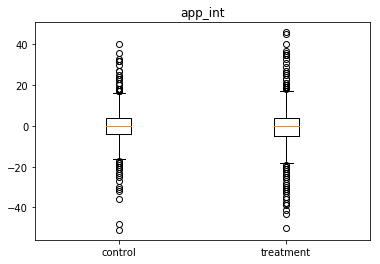

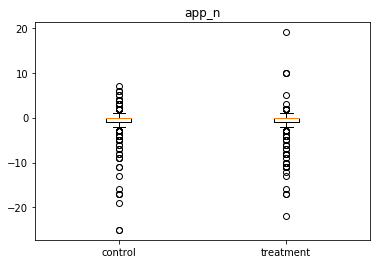

In [6]:
def do_test_boxplot(data, col):
    control = data[data.cond == 'control'][col]
    treatment = data[data.cond == 'treatment'][col]
    print(f'{col}: {stats.mannwhitneyu(control, treatment)}')

    fig, ax = plt.subplots()
    ax.boxplot([control, treatment], labels=['control', 'treatment'])
    ax.set(title=f'{heading}')

res.to_csv('output_short_videos.csv')
for heading in res.columns[5:7]:
    do_test_boxplot(res, heading)

In [21]:
to_compare = res.loc[((res.subject == 'nm') | (res.subject == 'nf')) & (res.int_pos == 'BC') & (res.status == 'F')]
to_compare_grpd = to_compare.groupby('cond')
control_app_ints = to_compare_grpd.get_group('control').loc[:,'app_int']
treatment_app_ints = to_compare_grpd.get_group('treatment').loc[:,'app_int']
stats.mannwhitneyu(control_app_ints, treatment_app_ints)

MannwhitneyuResult(statistic=785.5, pvalue=0.44616428762251903)